In [1]:
import numpy as np
import pandas as pd
import keras.preprocessing.sequence as sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('data_new.csv')



# Split data into train and test
train = df[df['交易日期'] < '2020-01-01']
test = df[df['交易日期'] >= '2020-01-01']
train_original = train.copy()
test_original = test.copy()

In [2]:
train.columns

Index(['交易日期', '到期月份(週別)', '開盤價', '最高價', '最低價', '收盤價', '漲跌價', '漲跌%', '成交量',
       '隔日漲跌價', '隔日收盤', '隔日漲跌', 'slowk', 'slowd', 'K-D', 'upperband',
       'middleband', 'lowerband', 'band_width', 'BIAS20', 'BIAS60', 'BIAS5',
       'OBV', 'macd', 'macdsignal', 'macdhist', 'RSI'],
      dtype='object')

In [4]:
train

,交易日期,到期月份(週別),開盤價,最高價,最低價,收盤價,漲跌價,漲跌%,成交量,隔日漲跌價,...,lowerband,band_width,BIAS20,BIAS60,BIAS5,OBV,macd,macdsignal,macdhist,RSI
0,2013-04-08,2013-04-01,7859,7870,7733,7739,-197,-0.0248,128621,-30.0,...,7717.375865,335.948270,-0.018560,-0.013948,-0.018417,-471573.0,-7.573789,-2.430880,-5.142909,39.234608
1,2013-04-09,2013-04-01,7717,7750,7697,7709,-28,-0.0036,84475,19.0,...,7695.664314,349.471372,-0.020507,-0.017639,-0.016885,-556048.0,-19.422695,-5.829243,-13.593451,37.446043
2,2013-04-10,2013-04-01,7737,7745,7713,7728,20,0.0026,59229,90.0,...,7688.404068,332.491865,-0.016124,-0.015019,-0.009612,-496819.0,-26.969014,-10.057197,-16.911817,39.332339
3,2013-04-11,2013-04-01,7776,7825,7759,7818,92,0.0119,84730,-34.0,...,7692.592288,306.015424,-0.003518,-0.003641,0.004162,-412089.0,-25.394546,-13.124667,-12.269879,47.420424
4,2013-04-12,2013-04-01,7822,7832,7783,7784,-32,-0.0041,64379,-21.0,...,7695.387027,279.825946,-0.006547,-0.008062,0.003662,-476468.0,-26.583843,-15.816502,-10.767341,44.980726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,2019-12-27,2020-01-01,12007,12026,12000,12025,18,0.0015,11513,44.0,...,11924.440447,204.919106,-0.000158,0.023207,-0.000183,2948690.0,68.423666,82.738683,-14.315017,55.253854
2299,2019-12-30,2020-01-01,12091,12125,12065,12069,-28,-0.0023,66062,13.0,...,11932.966018,198.667964,0.003050,0.026258,0.002126,3014752.0,67.319536,79.654854,-12.335317,57.711612
2300,2019-12-30,2020-01-01,12103,12110,12068,12082,-15,-0.0012,18175,-87.0,...,11953.684857,173.530286,0.003451,0.026576,0.001990,3032927.0,66.724340,77.068751,-10.344411,58.437978
2301,2019-12-31,2020-01-01,12029,12049,11992,11995,-74,-0.0061,74341,28.0,...,11950.809005,168.781990,-0.003340,0.018678,-0.004862,2958586.0,58.557456,73.366492,-14.809036,52.000674


In [3]:

all = ['開盤價', '最高價', '最低價', '收盤價', '漲跌價', '漲跌%', '成交量',
       '隔日漲跌價', '隔日漲跌', 'slowk', 'slowd', 'K-D', 'upperband', 'middleband',
       'lowerband', 'band_width', 'BIAS20', 'BIAS60', 'BIAS5', 'OBV', 'macd',
       'macdsignal', 'macdhist', 'RSI']
features = ['開盤價', '最高價', '最低價', '收盤價', '漲跌價', '漲跌%', '成交量',
              'slowk', 'slowd', 'K-D', 'upperband', 'middleband',
       'lowerband', 'band_width', 'BIAS20', 'BIAS60', 'BIAS5', 'OBV', 'macd',
       'macdsignal', 'macdhist', 'RSI']

train = train[['收盤價', '隔日收盤']]
test = test[['收盤價', '隔日收盤']]




In [4]:
scalar = MinMaxScaler()
train = pd.DataFrame(scalar.fit_transform(train))
test = pd.DataFrame(scalar.transform(test))
train.columns = ['收盤價', '隔日收盤']
test.columns = ['收盤價', '隔日收盤']

In [5]:
sequence_length = 60

# Convert the data into sequences
def create_sequences_and_targets(X, y, sequence_length):
    X_seq, y_target = [], []
    for i in range(sequence_length, len(X)):
        X_seq.append(X.iloc[i - sequence_length : i].values)
        y_target.append(y.iloc[i])  # Get the next value as the target
    return np.array(X_seq), np.array(y_target)

X_train_seq, y_train = create_sequences_and_targets(train['收盤價'], train['隔日收盤'], sequence_length)
X_test_seq, y_test = create_sequences_and_targets(test['收盤價'], test['隔日收盤'], sequence_length)

In [139]:
X_train_seq.shape

(2243, 60)

In [6]:
X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], X_train_seq.shape[1], 1)
X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], 1)

In [141]:
X_train_seq.shape

(2243, 60, 1)

In [142]:
y_train.shape

(2243,)

In [7]:
model = Sequential()

model.add(LSTM(32, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(16, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(8, return_sequences=False))
model.add(Dense(1))



model.compile(loss='mse', optimizer='adam')
model.fit(X_train_seq, y_train, epochs=50, batch_size=32)


Epoch 1/50
71/71 [==============================] - 6s 27ms/step - loss: 0.0433
Epoch 2/50
71/71 [==============================] - 2s 27ms/step - loss: 0.0027
Epoch 3/50
71/71 [==============================] - 2s 27ms/step - loss: 0.0023
Epoch 4/50
71/71 [==============================] - 2s 27ms/step - loss: 0.0023
Epoch 5/50
71/71 [==============================] - 2s 27ms/step - loss: 0.0022
Epoch 6/50
71/71 [==============================] - 2s 27ms/step - loss: 0.0022
Epoch 7/50
71/71 [==============================] - 2s 27ms/step - loss: 0.0022
Epoch 8/50
71/71 [==============================] - 2s 27ms/step - loss: 0.0020
Epoch 9/50
71/71 [==============================] - 2s 27ms/step - loss: 0.0020
Epoch 10/50
71/71 [==============================] - 2s 27ms/step - loss: 0.0019
Epoch 11/50
71/71 [==============================] - 2s 27ms/step - loss: 0.0019
Epoch 12/50
71/71 [==============================] - 2s 27ms/step - loss: 0.0017
Epoch 13/50
71/71 [==================

In [8]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [146]:
model.evaluate(X_test_seq, y_test)

predicted = pd.DataFrame(model.predict(X_test_seq))
predicted 


45/45 [==============================] - 1s 8ms/step


,0
0,0.919558
1,0.907127
2,0.894306
3,0.883916
4,0.869551
...,...
1404,1.488933
1405,1.486148
1406,1.482323
1407,1.473685


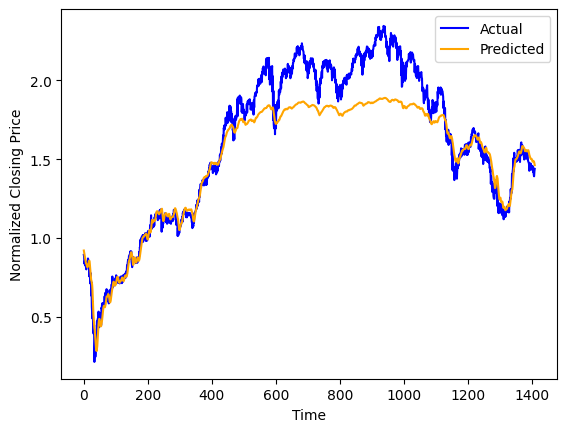

In [147]:
plt.plot(y_test, label='Actual', color='blue')
plt.plot(predicted, label='Predicted', color='orange')
plt.xlabel('Time')
plt.ylabel('Normalized Closing Price')

plt.legend()

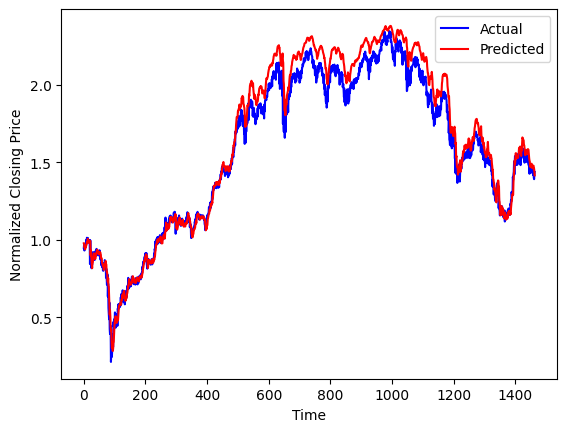

In [129]:
plt.plot(y_test, label='Actual', color='blue')
plt.plot(predicted, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Normalized Closing Price')

plt.legend()

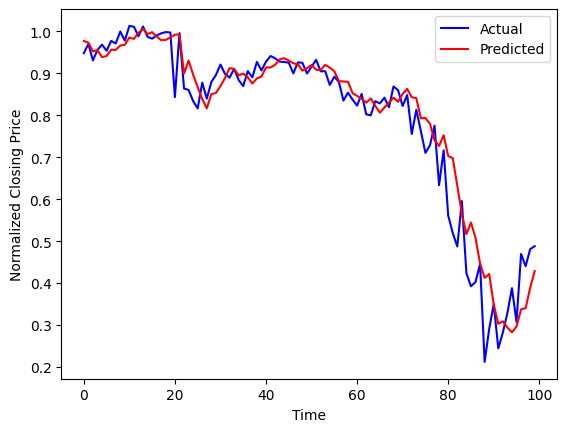

In [130]:
plt.plot(y_test[:100], label='Actual', color='blue')
plt.plot(predicted[:100], label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Normalized Closing Price')

plt.legend()

In [ ]:
mean_squared_error(model.predict(X_test))